### Simulation: Masternode Yield Farming

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/simulation","")
os.chdir(cwd)

from python.dev.helper import Helper

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor

from python.dev.agent import TokenAgent
from python.dev.agent import LPTokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.action import DepositAction
from python.dev.action import LPDepositChainAction
from python.dev.action import DepositChainAction
from python.dev.action import WithdrawChainAction
from python.dev.action import WithdrawAction
from python.dev.action import SwapAction
from python.dev.event import Mint
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.event import Swap

from python.dev.simulation.batch import WithdrawBatch
from python.dev.simulation.batch import DepositBatch
from python.dev.simulation.batch import SwapBatch
from python.dev.simulation.batch.set import BatchSet

from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel

from python.dev.lp import LiquidityPool
from python.dev.lp.event import LPEvent
from python.dev.lp.event import MintLPEvent
from python.dev.lp.event import DepositLPEvent
from python.dev.lp.event import SwapLPEvent

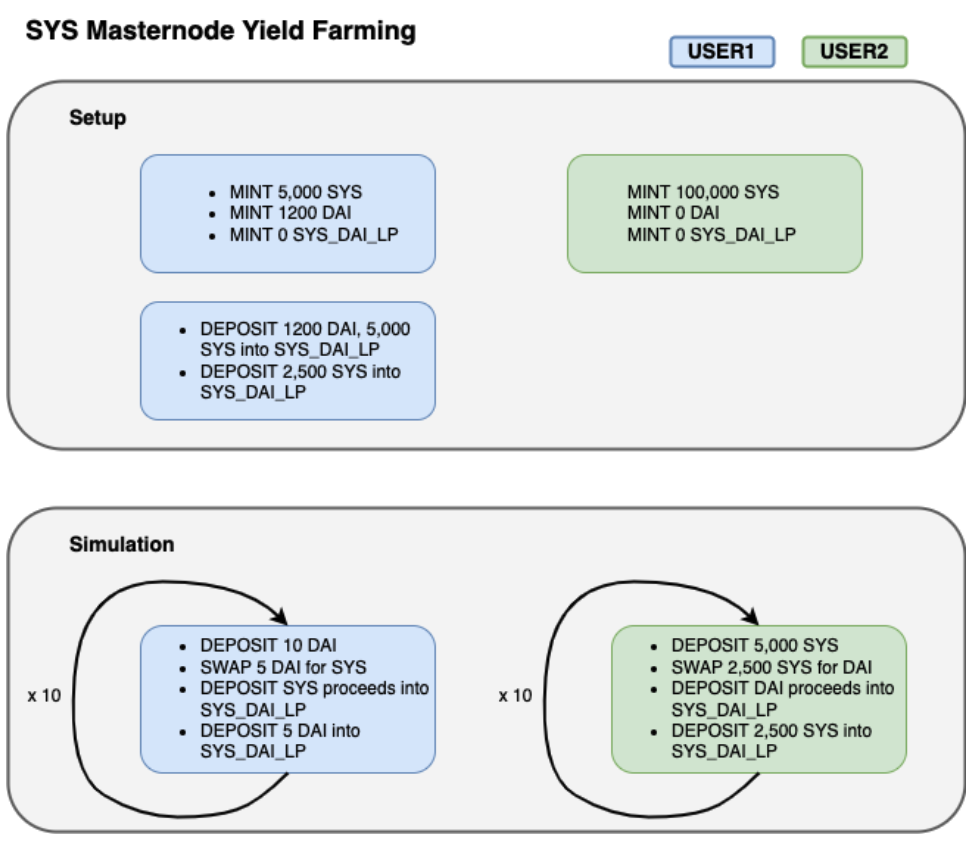

In [2]:
Image("images/jupyter/tutorials/masternode_nft.png", width = 600, height = 600)

### Initialize Agents

In [3]:
USER1 = UserAgent('USER1')
USER2 = UserAgent('USER2')

SYS = TokenAgent('SYS')
DAI = TokenAgent('DAI')

SYS_DAI_LP = LiquidityPool('SYS/DAI', USER1, SYS, DAI)
SYS_DAI = LPTokenAgent('SYS_DAI_LP', SYS_DAI_LP)

### Mint Tokens

In [4]:
apy = 0.1
t_delta = 109*24*3600

In [5]:
SYS_mint1 = Mint(5000, apy, True)
DAI_mint1 = Mint(5000, apy, True)
SYS_DAI_LP_mint1 = Mint(0, apy, True)

SYS_mint2 = Mint(100000, apy, True)
DAI_mint2 = Mint(0, apy, True)
SYS_DAI_LP_mint2 = Mint(0, apy, True)

In [6]:
m_action1 = MintAction(SYS_mint1, SYS, USER1)
m_action2 = MintAction(DAI_mint1, DAI, USER1)
m_action3 = MintAction(SYS_DAI_LP_mint1, SYS_DAI, USER1)

m_action4 = MintAction(SYS_mint2, SYS, USER2)
m_action5 = MintAction(DAI_mint2, DAI, USER2)
m_action6 = MintAction(SYS_DAI_LP_mint2, SYS_DAI, USER2)

### Setup Actions

In [7]:
sub_withdraw1 = Withdraw(apy, 1000, 0) 
w_action1 = WithdrawAction(sub_withdraw1, SYS, USER1, SYS_mint1.get_id())
d_action1 = LPDepositChainAction(w_action1, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())

In [8]:
sub_withdraw2 = Withdraw(apy, 1000, 0) 
w_action2 = WithdrawAction(sub_withdraw2, DAI, USER1, DAI_mint1.get_id())
d_action2 = LPDepositChainAction(w_action2, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())

### Batchset 1

In [9]:
deposit1 = Deposit(apy, 5000, t_delta) # 
sub_withdraw1 = Withdraw(apy, 2500, 0)
sub_deposit1 = Deposit(apy, 2500, t_delta)

In [10]:
d_action3 = DepositAction(deposit1, SYS, USER2, SYS_mint2.get_id())
sub_w_action1 = WithdrawAction(sub_withdraw1, SYS, USER2, SYS_mint2.get_id())
sub_d_action1 = DepositAction(sub_deposit1, DAI, USER2, DAI_mint2.get_id())
s_action1 = SwapAction(sub_w_action1, sub_d_action1)
w_action3 = WithdrawChainAction(s_action1, DAI, USER2, DAI_mint2.get_id())
d_action5 = LPDepositChainAction(w_action3, SYS_DAI, USER2, SYS_DAI_LP_mint2.get_id())


### Batchset 2

In [11]:
deposit2 = Deposit(apy, 50, t_delta)
sub_withdraw2 = Withdraw(apy, 25, 0)
sub_deposit2 = Deposit(apy, 25, t_delta)

In [12]:
d_action6 = DepositAction(deposit2, SYS, USER1, SYS_mint1.get_id())
sub_w_action2 = WithdrawAction(sub_withdraw2, SYS, USER1, SYS_mint1.get_id())
sub_d_action2 = DepositAction(sub_deposit2, DAI, USER1, DAI_mint1.get_id())
s_action2 = SwapAction(sub_w_action2, sub_d_action2)
w_action4 = WithdrawChainAction(s_action2, DAI, USER1, DAI_mint1.get_id())
d_action7 = LPDepositChainAction(w_action4, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())


### Populate event queue

In [13]:
q = EventQueue()
q.add_event(m_action1)
q.add_event(m_action2)
q.add_event(m_action3)
q.add_event(m_action4)
q.add_event(m_action5)
q.add_event(m_action6)

# Setup
q.add_event(w_action1)
q.add_event(d_action1)
q.add_event(w_action2)
q.add_event(d_action2)

In [14]:
for k in range(10):
    
    # Batchset #1
    q.add_event(d_action3)
    q.add_event(s_action1)
    q.add_event(w_action3)
    q.add_event(d_action5)

    # Batchset #2
    q.add_event(d_action6)
    q.add_event(s_action2)
    q.add_event(w_action4)
    q.add_event(d_action7)

### Execute events

In [15]:
orchestrator = SimulationOrchestrator(verbose = True)
executor = EventExecutor(q, orchestrator)
executor.run()

======== Action Tasks ===========
# num_tasks: 90 

MINT 5000 SYS for USER1
MINT 5000 DAI for USER1
MINT 0 SYS_DAI_LP for USER1
MINT 100000 SYS for USER2
MINT 0 DAI for USER2
MINT 0 SYS_DAI_LP for USER2
WITHDRAW 1000 SYS for USER1
DEPOSIT 1000 SYS_DAI_LP for USER1
WITHDRAW 1000 DAI for USER1
DEPOSIT 1000 SYS_DAI_LP for USER1
DEPOSIT 5000 SYS for USER2
SWAP 2500 DAI for USER2
WITHDRAW 2500 DAI for USER2
DEPOSIT 2500 SYS_DAI_LP for USER2
DEPOSIT 50 SYS for USER1
SWAP 25 DAI for USER1
WITHDRAW 25 DAI for USER1
DEPOSIT 25 SYS_DAI_LP for USER1
DEPOSIT 5000 SYS for USER2
SWAP 2500 DAI for USER2
WITHDRAW 2500 DAI for USER2
DEPOSIT 2500 SYS_DAI_LP for USER2
DEPOSIT 50 SYS for USER1
SWAP 25 DAI for USER1
WITHDRAW 25 DAI for USER1
DEPOSIT 25 SYS_DAI_LP for USER1
DEPOSIT 5000 SYS for USER2
SWAP 2500 DAI for USER2
WITHDRAW 2500 DAI for USER2
DEPOSIT 2500 SYS_DAI_LP for USER2
DEPOSIT 50 SYS for USER1
SWAP 25 DAI for USER1
WITHDRAW 25 DAI for USER1
DEPOSIT 25 SYS_DAI_LP for USER1
DEPOSIT 5000 SYS fo

### Analyze

In [16]:
tSYS = SYS.get_token()
tDAI = DAI.get_token()
tSYS_DAI = SYS_DAI.get_token()

SYS_addr1 = SYS.get_address(SYS_mint1.get_id())
DAI_addr1 = DAI.get_address(DAI_mint1.get_id())
SYS_DAI_addr1 = SYS_DAI.get_address(SYS_DAI_LP_mint1.get_id())

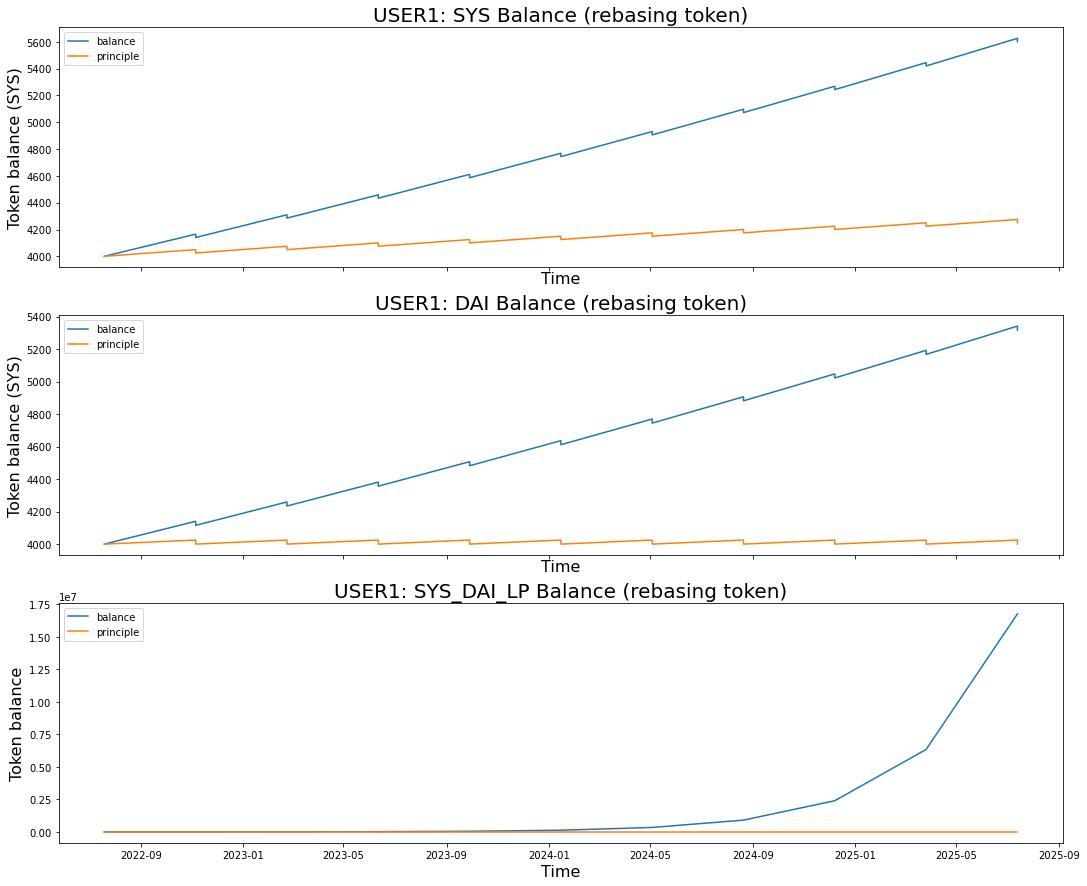

In [17]:
# Analyze Token balances

SYS_states1 = tSYS.get_state_series(SYS_addr1)
principle = SYS_states1.get_principle() 
balance = SYS_states1.get_balance() 
tSamp = SYS_states1.get_tstamp()  

fig, (SYS_ax, DAI_ax, SYS_DAI_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

SYS_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_ax.set_title("USER1: SYS Balance (rebasing token)", fontsize=20)
SYS_ax.set_ylabel("Token balance (SYS)", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_states1 = tDAI.get_state_series(DAI_addr1)
principle = DAI_states1.get_principle() 
balance = DAI_states1.get_balance() 
tSamp = DAI_states1.get_tstamp() 

DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
DAI_ax.set_title("USER1: DAI Balance (rebasing token)", fontsize=20)
DAI_ax.set_ylabel("Token balance (SYS)", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

SYS_DAI_states1 = tSYS_DAI.get_state_series(SYS_DAI_addr1)
principle = SYS_DAI_states1.get_principle() 
balance = SYS_DAI_states1.get_balance() 
tSamp = SYS_DAI_states1.get_tstamp() 

SYS_DAI_ax.plot(tSamp[2:], balance[2:], label='balance') 
SYS_DAI_ax.plot(tSamp[2:], principle[2:], label='principle') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Balance (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("Token balance", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()


In [18]:
SYS_addr2 = SYS.get_address(SYS_mint2.get_id())
DAI_addr2 = DAI.get_address(DAI_mint2.get_id())
SYS_DAI_addr2 = SYS_DAI.get_address(SYS_DAI_LP_mint2.get_id())

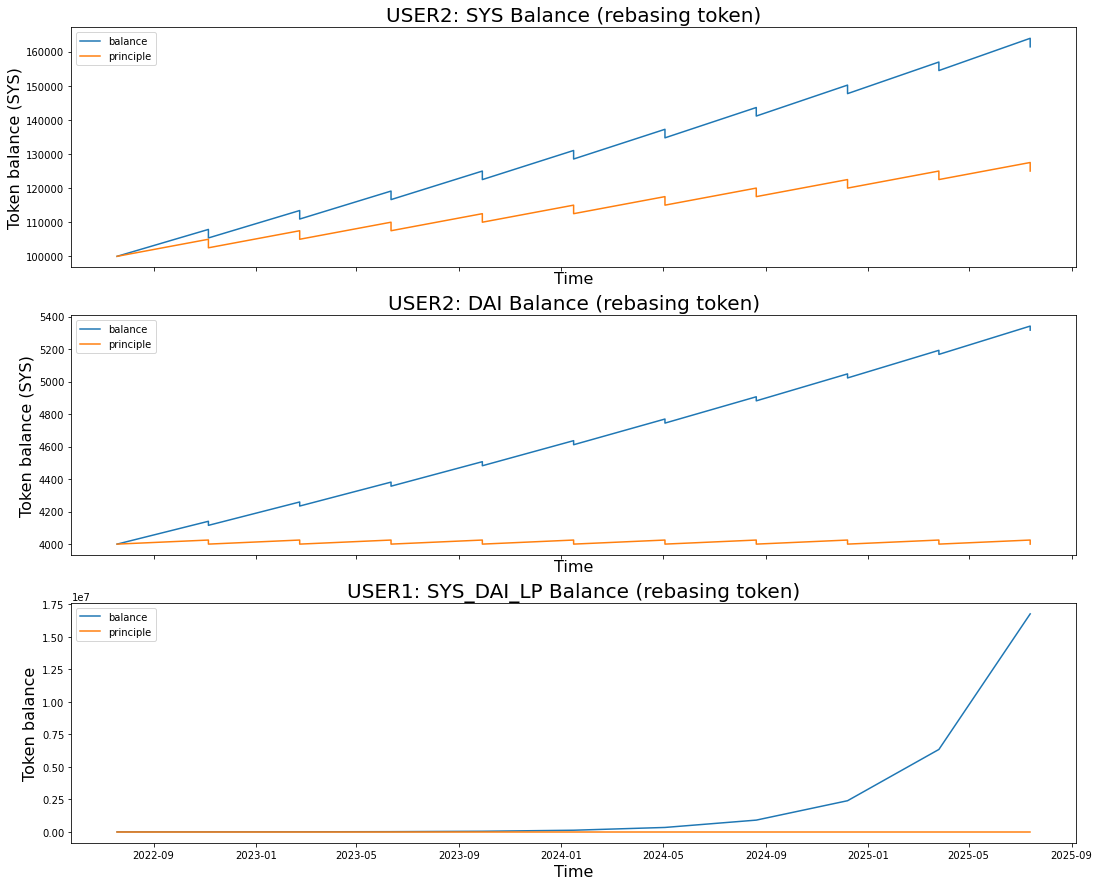

In [19]:
# Analyze Token balances

SYS_states2 = tSYS.get_state_series(SYS_addr2)
principle = SYS_states2.get_principle() 
balance = SYS_states2.get_balance() 
tSamp = SYS_states2.get_tstamp()  

fig, (SYS_ax, DAI_ax, SYS_DAI_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

SYS_ax.plot(tSamp, balance, label='balance') 
SYS_ax.plot(tSamp, principle, label='principle') 
SYS_ax.set_title("USER2: SYS Balance (rebasing token)", fontsize=20)
SYS_ax.set_ylabel("Token balance (SYS)", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_states2 = tDAI.get_state_series(DAI_addr1)
principle = DAI_states2.get_principle() 
balance = DAI_states2.get_balance() 
tSamp = DAI_states2.get_tstamp() 

DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
DAI_ax.set_title("USER2: DAI Balance (rebasing token)", fontsize=20)
DAI_ax.set_ylabel("Token balance (SYS)", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

SYS_DAI_states2 = tSYS_DAI.get_state_series(SYS_DAI_addr1)
principle = SYS_DAI_states2.get_principle() 
balance = SYS_DAI_states2.get_balance() 
tSamp = SYS_DAI_states2.get_tstamp() 

SYS_DAI_ax.plot(tSamp[2:], balance[2:], label='balance') 
SYS_DAI_ax.plot(tSamp[2:], principle[2:], label='principle') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Balance (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("Token balance", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()


In [20]:
#SYS_states1.get_principle() 

In [21]:
#DAI_states1.get_principle() 

In [22]:
#SYS_DAI_states1.get_principle() 

In [23]:
#SYS_states2.get_principle() 

In [24]:
#DAI_states2.get_principle() 

In [25]:
#SYS_DAI_states2.get_principle() 

In [26]:
tSamp = SYS_DAI_LP.get_lp_events().get_dates()
prices = SYS_DAI_LP.get_lp_events().get_prices()
liquidities = SYS_DAI_LP.get_lp_events().get_liquidity_values()